**Import Libraries**

In [ ]:
#Installing the required packages
!pip install librosa
!pip install keras
!pip install tensorflow
!pip install ffmpeg

In [42]:
#Importing the required libraries
import os
import glob
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import fftpack
from scipy.stats import kurtosis,skew,mode
import sklearn.preprocessing,sklearn.decomposition
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold,train_test_split
from keras import utils
import keras
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv1D, Conv2D, Flatten,Reshape, BatchNormalization, ZeroPadding2D,MaxPooling1D,AveragePooling1D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras import regularizers,optimizers
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.utils import to_categorical
import keras.backend as K
from keras.models import load_model
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

**Extract Training Dataset**

In [43]:
#Function to extract the training data
def get_training(original_path):
    
    # Load the training data csv file into a dataframe. 
    df = pd.read_csv(os.path.join(original_path,'train.csv'))

    # Creating folder to store the Numpy arrays if they don't exist.
    if not os.path.exists(os.path.join(original_path,'train_extracted')):
        os.makedirs(os.path.join(original_path,'train_extracted'))

    # Getting the file names of audios from the dataframe.
    audio_files = np.array(df['new_id'])

    # Load each audio file, save it as a numpy array
    for i in range(len(audio_files)):    
        d,r = librosa.load(os.path.join(original_path,'train',str(audio_files[i]).zfill(8)+".mp3"),mono=True)
        np.save(os.path.join(original_path, 'train_extracted',str(audio_files[i])+'.npy'),d)

**Extract Testing Dataset**

In [44]:
#Function to extract the testing data
def get_testing(original_path):

    # Load the test data csv file into a dataframe.
    df = pd.read_csv(os.path.join(original_path,'test_idx.csv'))

    # Creating folder to store the Numpy arrays if they don't exist.
    if not os.path.exists(os.path.join(original_path,'test_extracted')):
        os.makedirs(os.path.join(original_path,'test_extracted'))

    # Getting the file names of audios from the dataframe.
    audio_files = np.array(df['new_id'])

    # Load each audio file, save it as a numpy array
    for i in range(len(audio_files)):   
        d,r = librosa.load(os.path.join(original_path,'test',str(audio_files[i]).zfill(8)+".mp3"),mono=True)
        np.save(os.path.join(original_path, 'test_extracted',str(audio_files[i])+'.npy'),d)

**Extract MFCC Features**

In [45]:
#Function to extract mfcc features which takes a csv file and the extracted folder as arguments
def get_mfcc_features(original_path, csv_file, extracted_folder):

  # Load the csv file into a dataframe.
  df = pd.read_csv(os.path.join(original_path, csv_file ))

  # Get the audio file names.
  audio_extracted = np.array(df['new_id'])

  # Create an empty list to store the features.
  mfcc_features=list()

  # Looping on each Audio sequence array.
  for i in range(len(audio_extracted)):
        
    # Load the Audio sequence.
    audio_file_data= np.load(os.path.join(original_path, extracted_folder, str(audio_extracted[i])+'.npy'))

    # Calculate MFCC coefficients for the audio sequence.
    mfcc_data = librosa.feature.mfcc(y=audio_file_data,sr=22050)

    # Calculating various statistic measures on the coefficients.
    mean_mfcc = np.mean(mfcc_data, axis=1)
    median_mfcc= np.median(mfcc_data,axis=1)
    std_mfcc = np.std(mfcc_data, axis=1)
    skew_mfcc = skew(mfcc_data, axis=1)
    kurt_mfcc = kurtosis(mfcc_data, axis=1)
    maximum_mfcc = np.amax(mfcc_data, axis=1)
    minimum_mfcc = np.amin(mfcc_data, axis=1)

    # Concatinating all the statistic measures and adding to the feature list.
    addList = np.concatenate((mean_mfcc,median_mfcc,std_mfcc,skew_mfcc,kurt_mfcc,maximum_mfcc,minimum_mfcc))
    mfcc_features.append(addList) 
    
  # Return feature list.
  return mfcc_features

**Extract PCA Features**

In [46]:
#Function to extract pca features which takes a csv file and the extracted folder as arguments
def get_all_features(original_path, csv_file, extracted_folder):

  # Load the csv file into a dataframe.
  df = pd.read_csv(os.path.join(original_path, csv_file ))

  # Get the audio file names.
  audio_extracted = np.array(df['new_id'])

  # Create an empty list to store the features.
  all_features=list()

  # Looping on each Audio sequence array.
  for i in range(len(audio_extracted)):

    # Load the Audio sequence.
    audio_file_data= np.load(os.path.join(original_path, extracted_folder, str(audio_extracted[i])+'.npy'))

    # Calculate MFCC on the audio sequence.
    mfcc_data = librosa.feature.mfcc(y=audio_file_data,sr=22050)

    # Calculate Root Mean Square Error.
    rmse= librosa.feature.rms(y=audio_file_data)

    # Calculate Chroma STFTs.
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=audio_file_data, sr=22050))

    # Calculate Spectral Centroid.
    spec_cent = librosa.feature.spectral_centroid(y=audio_file_data, sr=22050)

    # Calculate Spectral Bandwidth.
    spec_bw = librosa.feature.spectral_bandwidth(y=audio_file_data, sr=22050)

    # Calculate Rolloff.
    rolloff = librosa.feature.spectral_rolloff(y=audio_file_data, sr=22050)

    # Calculate Zero Crossing Rate.
    zcr =librosa.feature.zero_crossing_rate(audio_file_data)

    # Calculate and append statistic features for all the above data features.
    addList = np.concatenate((np.mean(mfcc_data, axis=1),np.median(mfcc_data,axis=1),np.std(mfcc_data, axis=1),skew(mfcc_data, axis=1),kurtosis(mfcc_data, axis=1),np.atleast_1d(np.mean(rmse)),np.atleast_1d(np.median(rmse)),np.atleast_1d(np.std(rmse)),np.atleast_1d(skew(rmse,axis=1)),np.atleast_1d(kurtosis(rmse,axis=1)),np.atleast_1d(np.mean(chroma_stft)),np.atleast_1d(np.median(chroma_stft)),np.atleast_1d(np.std(chroma_stft)),np.atleast_1d(skew(chroma_stft)),np.atleast_1d(kurtosis(chroma_stft)),np.atleast_1d(np.mean(spec_cent)),np.atleast_1d(np.median(spec_cent)),np.atleast_1d(np.std(spec_cent)),np.atleast_1d(skew(spec_cent,axis=1)),np.atleast_1d(kurtosis(spec_cent,axis=1)),np.atleast_1d(np.mean(spec_bw)),np.atleast_1d(np.median(spec_bw)),np.atleast_1d(np.std(spec_bw)),np.atleast_1d(skew(spec_bw,axis=1)),np.atleast_1d(kurtosis(spec_bw,axis=1)),np.atleast_1d(np.mean(rolloff)),np.atleast_1d(np.median(rolloff)),np.atleast_1d(np.std(rolloff)),np.atleast_1d(skew(rolloff,axis=1)),np.atleast_1d(kurtosis(rolloff,axis=1)),np.atleast_1d(np.mean(zcr)),np.atleast_1d(np.median(zcr)),np.atleast_1d(np.std(zcr)),np.atleast_1d(skew(zcr,axis=1)),np.atleast_1d(kurtosis(zcr,axis=1)),np.amax(mfcc_data, axis=1),np.amin(mfcc_data, axis=1)))
    all_features.append(addList) 
    
  return all_features

**Apply PCA on All Features**

In [47]:
#Function to extract the features of training and testing data
def get_pca_features(original_path, train_csv, train_extracted,test_csv, test_extracted,no_of_components):

  #no_of_components specify the required number of components
  # Extract all the best features for the train and test audio sequences.
  train_features=get_all_features(original_path, train_csv, train_extracted)
  test_features =get_all_features(original_path, test_csv, test_extracted)

  # Standardize the features.
  sc = StandardScaler(with_mean=False)
  train_features = sc.fit_transform(train_features)
  test_features = sc.transform(test_features)

  # Apply PCA with no of components satisfying the explained variance ratio.
  pca = sklearn.decomposition.PCA()
  pca.fit(train_features)
  cumsum = np.cumsum(pca.explained_variance_ratio_)
  no_of_components = np.argmax(cumsum >= 0.95) + 1
  pca = sklearn.decomposition.PCA(n_components=no_of_components)

  # Fit and Transform training and testing data.
  train_features = pca.fit_transform(train_features)
  test_features = pca.transform(test_features)
    
  return train_features,test_features

**Extract Spectrograms**

In [63]:
#Function to extract spectrograms for Neural Network
def get_spectrograms(original_path, train_csv, train_extracted,test_csv, test_extracted):

  # Read the train_csv for Training Dataset file names.
  df = pd.read_csv(os.path.join(original_path, train_csv ))
  audio_extracted = np.array(df['new_id'])
  labels = np.array(df['genre'])

  # Intializing empty list for storing spectrograms and labels.
  X_train = []
  Y_train = []
  X_test = []  

  # Looping through the Training Data Audio sequences.
  for i in range(len(audio_extracted)):

    # Load Audio Sequence, calculate the Mel spectrogram and append it to list.
    audio_file_data = np.load(os.path.join(original_path, train_extracted, str(audio_extracted[i])+'.npy'))
    mel_spec = librosa.power_to_db(librosa.feature.melspectrogram(y=audio_file_data[:650000],n_mels=128,hop_length=2048),ref=np.max)
    X_train.append(mel_spec)
    Y_train.append(labels[i])  

  # Read the test_csv for Testing Dataset file names.
  df = pd.read_csv(os.path.join(original_path, test_csv))
  audio_extracted = np.array(df['new_id'])

  # Looping through the testing data audio sequences.
  for i in range(len(audio_extracted)):

    # Load Audio Sequence, calculate the Mel spectrogram and append it to list.
    audio_file_data = np.load(os.path.join(original_path, test_extracted, str(audio_extracted[i])+'.npy'))
    mel_spec = librosa.power_to_db(librosa.feature.melspectrogram(y=audio_file_data[:650000],n_mels=128,hop_length=2048),ref=np.max)
    X_test.append(mel_spec)
  
  # Converting the lists into numpy arrays.
  X_train = np.array(X_train)
  Y_train = np.array(Y_train).reshape(len(Y_train),1)
  X_test = np.array(X_test)

  # Splitting the training features into Training and Validation.
  stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
  for train_index, test_index in stratified_split.split(X_train, Y_train):
        training_data,train_labels=X_train[train_index],Y_train[train_index]
        val_data,val_labels=X_train[test_index],Y_train[test_index] 
  
  # One hot encoding the Training and validation labels.
  Y_train = to_categorical(train_labels,6)
  Y_val = to_categorical(val_labels,6)

  # Reshaping the features into the form (rows, columns, 1) for Convolutional Neural Networks.
  X_train=[training_data[i].reshape(len(training_data[i]),len(training_data[i][0]),1) for i in range(len(training_data))]
  X_val=[val_data[i].reshape(len(val_data[i]),len(val_data[i][0]),1) for i in range(len(val_data))]
  X_test = [X_test[i].reshape(len(X_test[i]),len(X_test[i][0]),1) for i in range(len(X_test))]

  return  X_train,Y_train,X_val,Y_val,X_test

**Random Forest Classifier**

In [50]:
#Function to use Random Forest classifier
def random_forest(X_train,Y_train,X_test):

  # Intialize Random Forest classifier with number of trees as 800.
  random_forest = RandomForestClassifier(n_estimators= 800)

  # Fit Training Dataset.
  random_forest.fit(X_train, Y_train)

  # Predict and return labels.
  return random_forest.predict(X_test)

**SVM Classifier**

In [51]:
#Function to use Support Vector Machines classifier
def svm_classifier(X_train,Y_train,X_test):

  # Intialize SVM classifier with One-vs-Rest decision function.
  svm_model = svm.SVC(decision_function_shape='ovr')

  # Fit the Training Dataset.
  svm_model.fit(X_train, Y_train)

  # Predict and return labels.
  return svm_model.predict(X_test)

**2-Dimensional CNN Classifier**

In [52]:
#Function to use CNN classifier
def cnn_classifier(inputShape):

  # Intializing the model sequential.
  model = Sequential()

  # Adding Layers.  
  model.add(Conv2D(32, (4, 4), input_shape=inputShape))
  model.add(MaxPooling2D((4, 4)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(64, (4, 4), padding="same"))
  model.add(MaxPooling2D((4, 4)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(64, (2, 2), padding="same"))
  model.add(MaxPooling2D((2, 2)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(6,activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  

  print(model.summary())
  
  return model

In [53]:
#Funtion to retrieve the labels of training data
def get_labels(original_path,csv_file):

  # Load the csv file into a dataframe.
  df = pd.read_csv(os.path.join(original_path, csv_file ))

  # Return the labels.
  labels = np.array(df['genre'])

  return labels

In [54]:
#Funtion to standardize the features
def standardize_features(X_train,X_test):

  # Initialize standard scalar with zero mean
  sc = StandardScaler(with_mean=False)

  # Fit and transform the Training Dataset.
  X_train= sc.fit_transform(X_train)

  # Transform the testing set.
  X_test = sc.transform(X_test)
  
  return X_train,X_test

In [62]:
#Function to plot the confusion matrix
def plot_confusion_matrix(y_true,y_pred,label_names,classifier):
    
    # Calculate the confusion matrix using the expected and predicted values.
    confusion_mat = confusion_matrix(np.array(y_true),y_pred,label_names)
    
    #  Show the confusion matrix values.
    fig = plt.figure(figsize=(5,5))
    plt.imshow(confusion_mat, cmap=plt.cm.Blues, interpolation='nearest')
    
    # Set the x, y and title labels for the plot.
    plt.xlabel("Expected Outputs", fontsize=10)
    plt.ylabel("Actual Outputs", fontsize=10)
    plt.title("Confusion Matrix of "+ classifier + " classifier",fontsize=12)
    
    # Arrange the label names on the x and y axis.
    plt.xticks(np.arange(len(label_names)), label_names, rotation='75')
    plt.yticks(np.arange(len(label_names)), label_names)
    plt.tick_params(axis='both', labelsize='10')
    plt.tight_layout()
    for (y, x), label in np.ndenumerate(confusion_mat):
        if label != 0:
            plt.text(x,y,label,ha='center',va='center', size='12')
            
    # Show the plot
    plt.show()

In [60]:
#Function to perform cross validation
def cross_validate(X_train,Y_train,data_rep):

 # Choose classifiers based on the Data Representation.
 if data_rep=="mfcc":
    clf = random_forest
    classifier="Random Forest"
    sc= StandardScaler()
    X_train = sc.fit_transform(X_train)
 elif data_rep=="pca":
    clf = svm_classifier
    classifier="SVM"

 #Create the list with actual Label names.
 label_names=["Rock","Pop","Folk","Instrumental","Electronic","Hip-Hop"]

 # Create a Stratified KFold with 5 splits.
 k_fold = StratifiedKFold(n_splits=5,shuffle=True)

 # Create two empty lists to keep track of accuracies for plotting and predictions for confusion matrix.
 accuracies_clf = list()
 predictions_clf = list()
 actual_predictions = list()

 # Split the Dataset and Loop through each fold.
 for train_index, test_index in k_fold.split(X_train,Y_train):

    # Split the Dataset into Training and Validation.
    x_train, x_test = X_train[train_index], X_train[test_index]
    y_train, y_test = Y_train[train_index], Y_train[test_index]    

    # Fit and Predict the current fold using the classifier.
    pred = clf(x_train,y_train,x_test)

    # Append the accuracies and predictions.
    predictions_clf.append(pred)
    actual_predictions.append(y_test)
    accuracies_clf.append(accuracy_score(pred,y_test))
 
 # Get the corresponding label names for the predictions.
 predictions_clf = np.array(predictions_clf).flatten()
 actual_predictions = np.array(actual_predictions).flatten()
 predictions_clf= [label_names[predictions_clf[i]] for i in range(len(predictions_clf))]
 actual_predictions= [label_names[actual_predictions[i]] for i in range(len(actual_predictions))]

 # Plot the confusion matrix for the classifier.
 plot_confusion_matrix(actual_predictions,predictions_clf,label_names,classifier)

 # Plot the accuracy of the classifier for different folds
 plt.plot([1,2,3,4,5],accuracies_clf)
 plt.xticks(np.arange(1,5,1))
 plt.xlabel("5-Fold CV")
 plt.ylabel("Accuracy")
 plt.show() 

 # Calculate and print the accuracy range with 99% confidence interval
 accuracy_clf= accuracy_score(predictions_clf,actual_predictions)
 radius_clf = 2.58 * np.sqrt(accuracy_clf*(1-accuracy_clf)/len(predictions_clf))
 accuracy_clf_min =  (accuracy_clf - radius_clf)
 accuracy_clf_max =  (accuracy_clf + radius_clf)

 print('\n\n Accuracy of '+ classifier +' on Validation Dataset is ' + str(accuracy_clf))
 print('\n At 99% Confidence Interval :')
 print('\n The Accuracy of ' + classifier + ' is likely between ' + str(accuracy_clf_min) + ' and ' + str(accuracy_clf_max))

**Extract Training and Testing Audio files into Numpy Arrays**

In [ ]:
# Set the path of the project folder which has train, test folders and train.csv, test_idx.csv
original_path = os.path.join("C:\\project3")

# Extract train and test dataset into numpy arrays and save them
get_training(original_path)
get_testing(original_path)

**SVM on PCA**

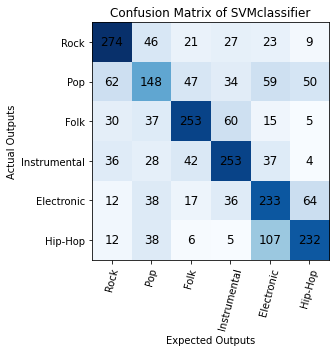

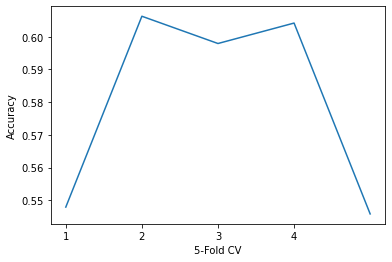



 Accuracy of SVM on Validation Dataset is 58.04166666666667

 At 99% Confidence Interval :

 The Accuracy of SVM is likely between 55.4427453163954 and 60.64058801693793


In [58]:
# Extract PCA features.
X_train,X_test = get_pca_features(original_path,'train.csv','train_extracted','test_idx.csv','test_extracted',100)
Y_train = get_labels(original_path,'train.csv')

# Cross Validate PCA Features.
cross_validate(np.array(X_train),np.array(Y_train),"pca")

# Classify PCA Test Features using SVM classifier.
y_test_svm = svm_classifier(X_train,Y_train,X_test)
Y_test = pd.read_csv(os.path.join(original_path,'test_idx.csv'))
Y_test['genre'] = y_test_svm.tolist()
Y_test = Y_test.rename(columns={"new_id":"id"})
Y_test.to_csv(os.path.join(original_path,'predict_svm.csv'),index=False)

**Random Forest on MFCC**

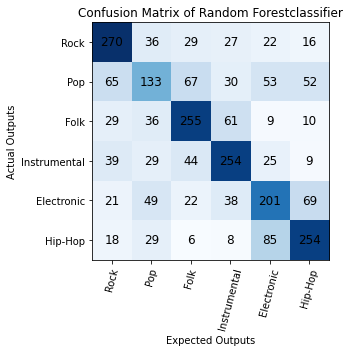

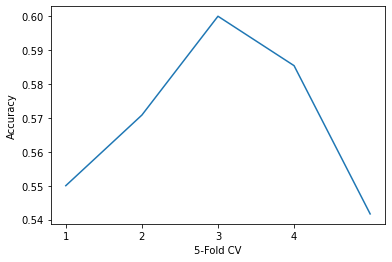



 Accuracy of Random Forest on Validation Dataset is 56.958333333333336

 At 99% Confidence Interval :

 The Accuracy of Random Forest is likely between 54.3507556144732 and 59.565911052193464


In [61]:
# Extract MFCC features and standardize them.
X_train = get_mfcc_features(original_path,'train.csv','train_extracted')
Y_train = get_labels(original_path,'train.csv')
X_test = get_mfcc_features(original_path,'test_idx.csv','test_extracted')
X_train,X_test = standardize_features(X_train,X_test)

# Cross Validate MFCC Features.
cross_validate(np.array(X_train),np.array(Y_train).flatten(),"mfcc")

# Classify MFCC Test Features using Random Forest Classifier.
y_test_rf = random_forest(X_train,Y_train,X_test)
Y_test = pd.read_csv(os.path.join(original_path,'test_idx.csv'))
Y_test['genre'] = y_test_rf.tolist()
Y_test = Y_test.rename(columns={"new_id":"id"})
Y_test.to_csv(os.path.join(original_path,'predict_rf.csv'),index=False)

**2-D CNN on Spectrograms**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 125, 315, 32)      544       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 78, 32)       0         
 2D)                                                             
                                                                 
 activation_3 (Activation)   (None, 31, 78, 32)        0         
                                                                 
 batch_normalization_3 (Batc  (None, 31, 78, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 31, 78, 64)        32832     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 19, 64)       

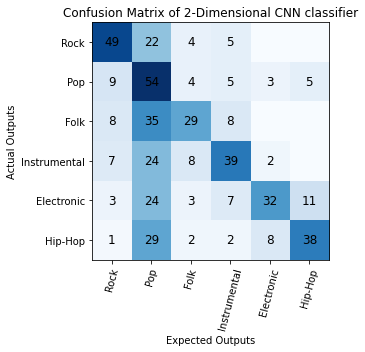



 Accuracy of 2-D CNN on Validation Dataset is 50.208333333333336


 At 99% Confidence Interval :

 The Accuracy of 2-D CNN is likely between 44.320366951637595 and 56.09629971502906


In [64]:
# Get the spectrograms
X_train,Y_train,X_val,Y_val, X_test = get_spectrograms(original_path,'train.csv','train_extracted', 'test_idx.csv','test_extracted')
label_names=["Rock","Pop","Folk","Instrumental","Electronic","Hip-Hop"]

# Applying 2-D Convolution Neural Network on the spectrograms.
model = cnn_classifier(X_train[0].shape)
model.fit(np.array(X_train), Y_train, epochs=20, batch_size=32, validation_data= (np.array(X_val), Y_val))

# Predict the Test dataset using the model and save results to a CSV file.
Y_test_nn = np.argmax(model.predict(np.array(X_test)),axis=1)
Y_test = pd.read_csv(os.path.join(original_path,'test_idx.csv'))
Y_test['genre'] = Y_test_nn.tolist()
Y_test = Y_test.rename(columns={'new_id':'id'})
Y_test.to_csv(os.path.join(original_path,'predict_cnn.csv'),index=False)

# Plot Confusion matrix using validation predictions.
Y_val_pred = np.argmax(model.predict(np.array(X_val)), axis=1)
Y_val_true = np.argmax(Y_val, axis=1)
Y_val_pred= [label_names[Y_val_pred[i]] for i in range(len(Y_val_pred))]
Y_val_true= [label_names[Y_val_true[i]] for i in range(len(Y_val_true))]
plot_confusion_matrix(Y_val_true,Y_val_pred,label_names,"2-Dimensional CNN")

accuracy= accuracy_score(Y_val_pred,Y_val_true)
radius = 2.58 * np.sqrt(accuracy*(1-accuracy)/len(Y_val_true))
accuracy_min =  (accuracy - radius)
accuracy_max =  (accuracy + radius)

print('\n\n Accuracy of 2-D CNN on Validation Dataset is ' + str(accuracy))
print('\n\n At 99% Confidence Interval :')
print('\n The Accuracy of 2-D CNN is likely between ' + str(accuracy_min) + ' and ' + str(accuracy_max)) 
